# HW 3 - Synonym Detection In Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Summer 2022`__

In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning. This is similar to the intuition behind the word2vec algorithm.

This will be your first assignment working in Spark. You'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:  
* ... __define__ the terms `one-hot encoding`, `co-occurrence matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __identify__ when it makes sense to take a stripe approach and when to use pairs
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 

__RECOMMENDED READING FOR HW3__:	
Your reading assignment for weeks 4 and 5 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings, especially when it comes to the similarity formulas -- they are directly relevant to this assignment.

DITP Chapter 4 - Inverted Indexing for Text Retrieval. While this text is specific to Hadoop, the Map/Reduce concepts still apply.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run review the following  and run the code cells  to confirm your setup.

## Data and HW output vs notebook Locations: private data bucket versus dataproc staging bucket

When you create a DataProc cluster, HDFS is used as the default filesystem. In this course, we override this behavior by setting the defaultFS as a Cloud Storage bucket. The benefits of using Cloud Storage buckets are that your job results get to persist beyond the lifetime of the cluster (and btw latency on these cloud buckets is super low).

In this HW, you use a cloud bucket (and folders on them), known as DATA_BUCKET, as input and output for the Spark Apps that you will develop as part of your submission.  
The datasets for this homework are preloaded into your `private Data Bucket` on Google Cloud. Recall that you created a private data bucket during the first week of semester. You may have called it w261-<your initials>. Jimi's bucket name is `w261-jgs`. To facilitate ease of access, we have set up location variables for the course-related data buckets. Your private data bucket  can be accessed via: 

* `os.getenv('DATA_BUCKET','')` 

This DATA_BUCKET will be used for hosting the input data for this assignment and also to store output from your HW Assignment apps.
Associated with each DataProc cluster is a persistant storage bucket that we refer to as the DataProc Staging Bucket. You will be using this staging bucket to store notebooks and other files associated with your HW assignments, and  live sessions. The location of the staging bucket  is made available via `os.getenv("STAGING_BUCKET")`. Since this bucket is persistent, we will no longer need to snapshot your student workspaces. 
    
For more background on Dataproc staging  buckets please see:
* https://cloud.google.com/dataproc/docs/concepts/configuring-clusters/staging-bucket

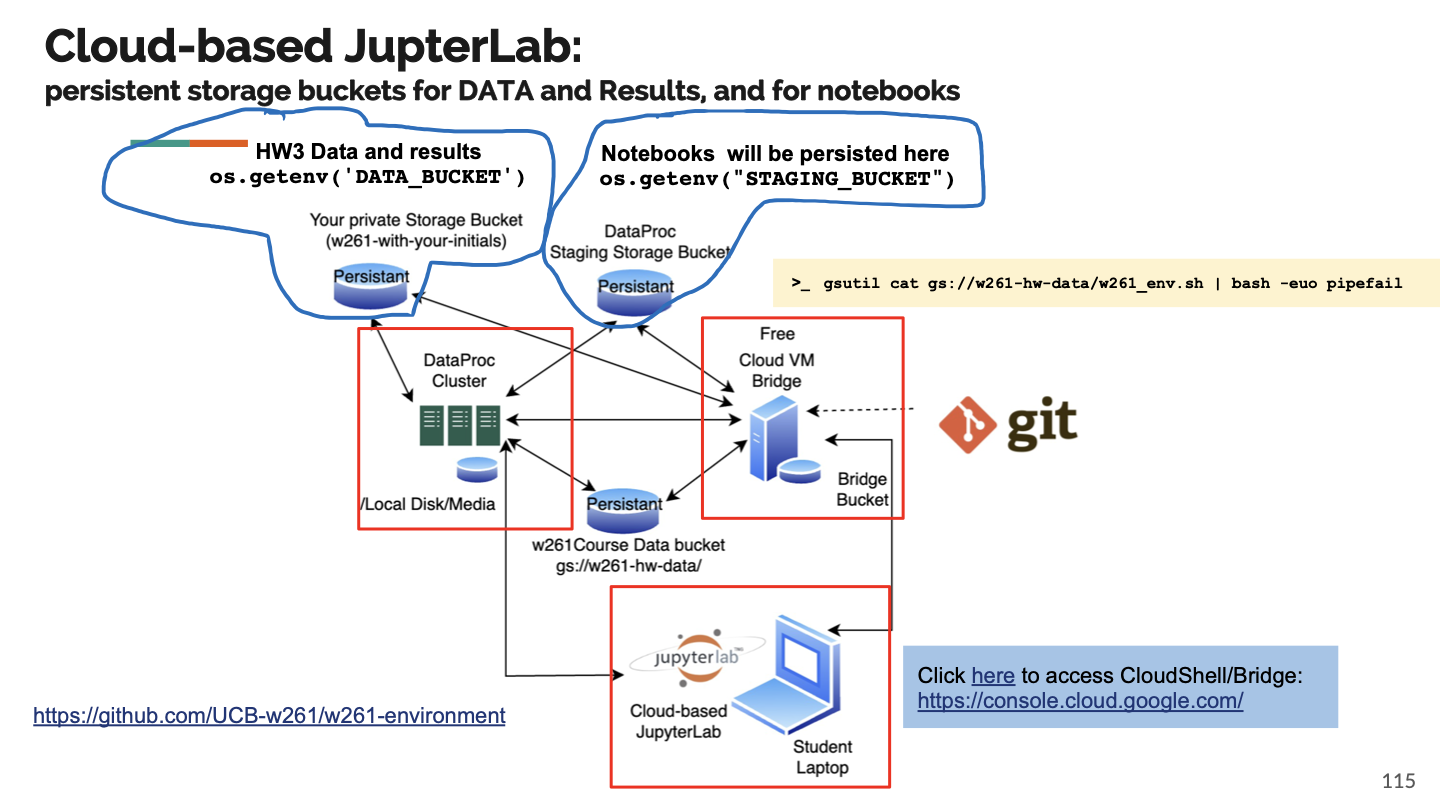

In [ ]:
# Access your personal data bucket and see whats there
import os
DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
HW3_FOLDER = f"{DATA_BUCKET}/main/Assignments/HW3/docker/student"
print(f"Personal Data bucket:  {DATA_BUCKET}")
!gsutil ls -lh  {HW3_FOLDER}  #lets have a look the HW3 folder on our private storage bucket


In [ ]:
#import os
#os.environ["STAGING_BUCKET"] =  "gs://dataproc-staging-us-central1-913378501339-ychjbide/"

In [ ]:
# Access staging bucket and see whats there
import os
print(f"STAGING_BUCKET location: {os.getenv('STAGING_BUCKET')}")
!gsutil ls -lh {os.getenv("STAGING_BUCKET")}notebooks/jupyter

In [ ]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# store path to notebook
#PWD = !pwd
#PWD = PWD[0]

In [ ]:
#sc.stop()

In [ ]:
# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .config('spark.history.ui.port', 35551) \
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [ ]:
# get Spark Session info (RUN THIS CELL AS IS)
spark #NOTE the Spark UI link provided below as output from this command does not work. See next section on how to get that working.

## OPTIONAL: Setup Spark UI (jobs and stages)

Web UI (aka Application UI or webUI or Spark UI) is the web interface of a running Spark application to monitor and inspect Spark job executions in a web browser. The following is a screenshot of the Spark UI. Feel free to skip this section.  

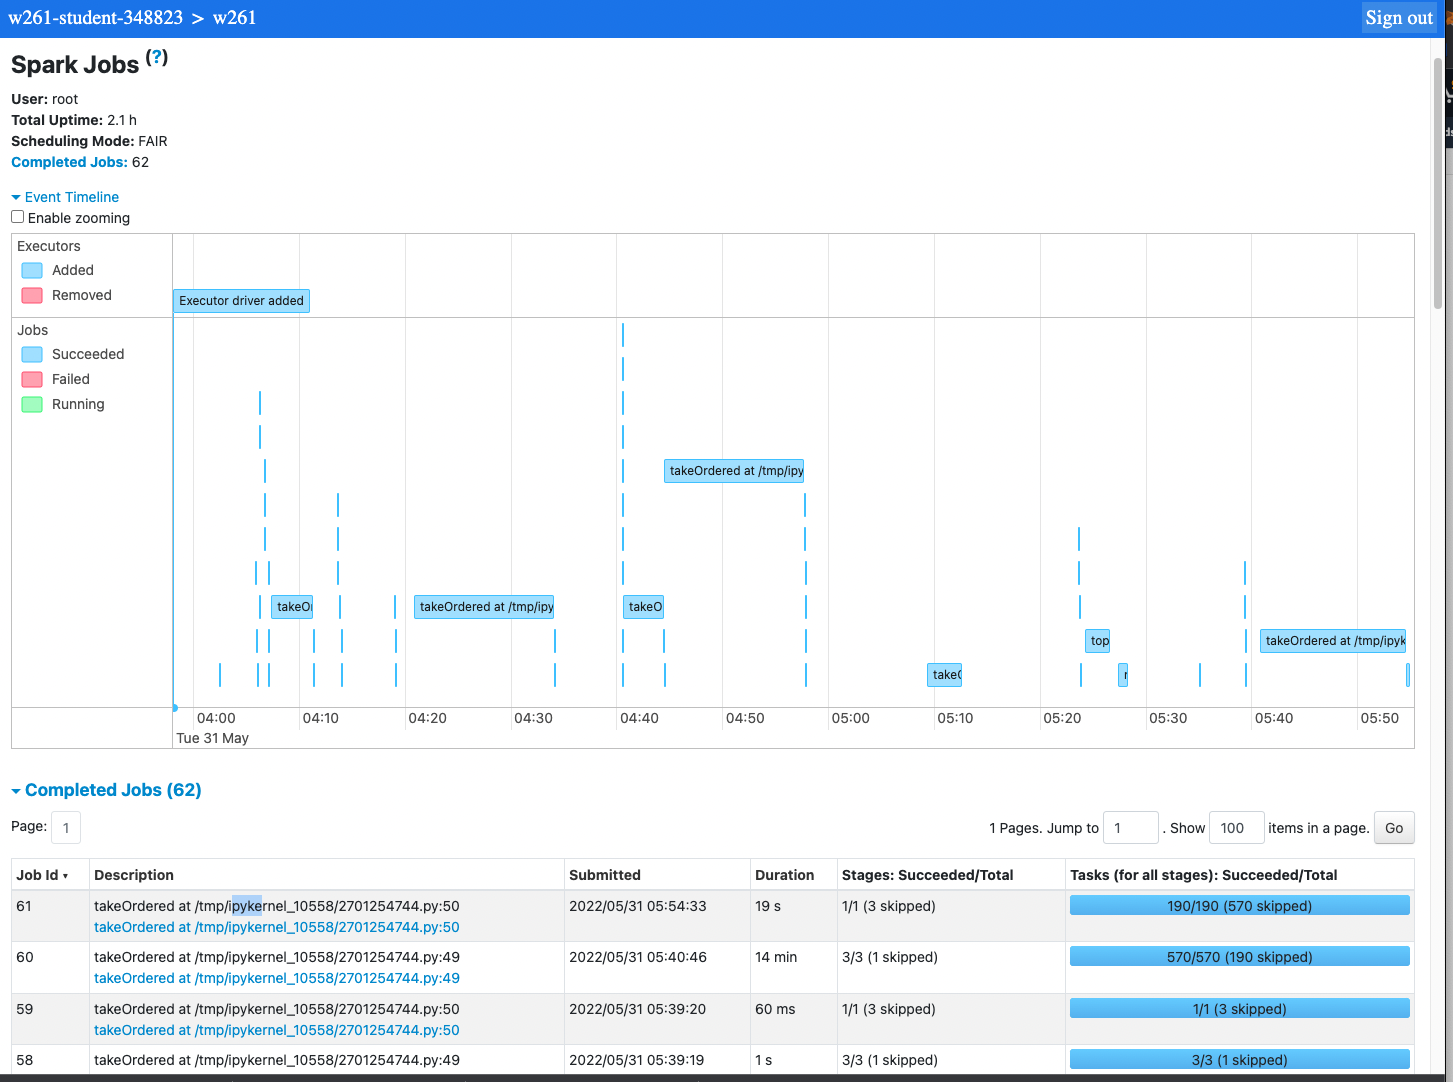

### OPTIONAL:  to view the Spark UI (jobs and stages) 

In [ ]:
# Optional  to view the Spark UI (jobs and stages) 

ui_port = spark._repr_html_().split(".internal:")[-1].split('"')[0]
print("Copy the following command (and swap out the ZONE for your cluster zone) to cloud shell and run as shown in the screenshot below. \nAnd click on the PREVIEW ON PORT 8080 menu option .")
f'gcloud compute ssh w261-m --zone us-central1-b --ssh-flag "-L 8080:localhost:{ui_port}"' 
# expect 'gcloud compute ssh w261-m --zone us-central1-b --ssh-flag "-L 8080:localhost:37649"'

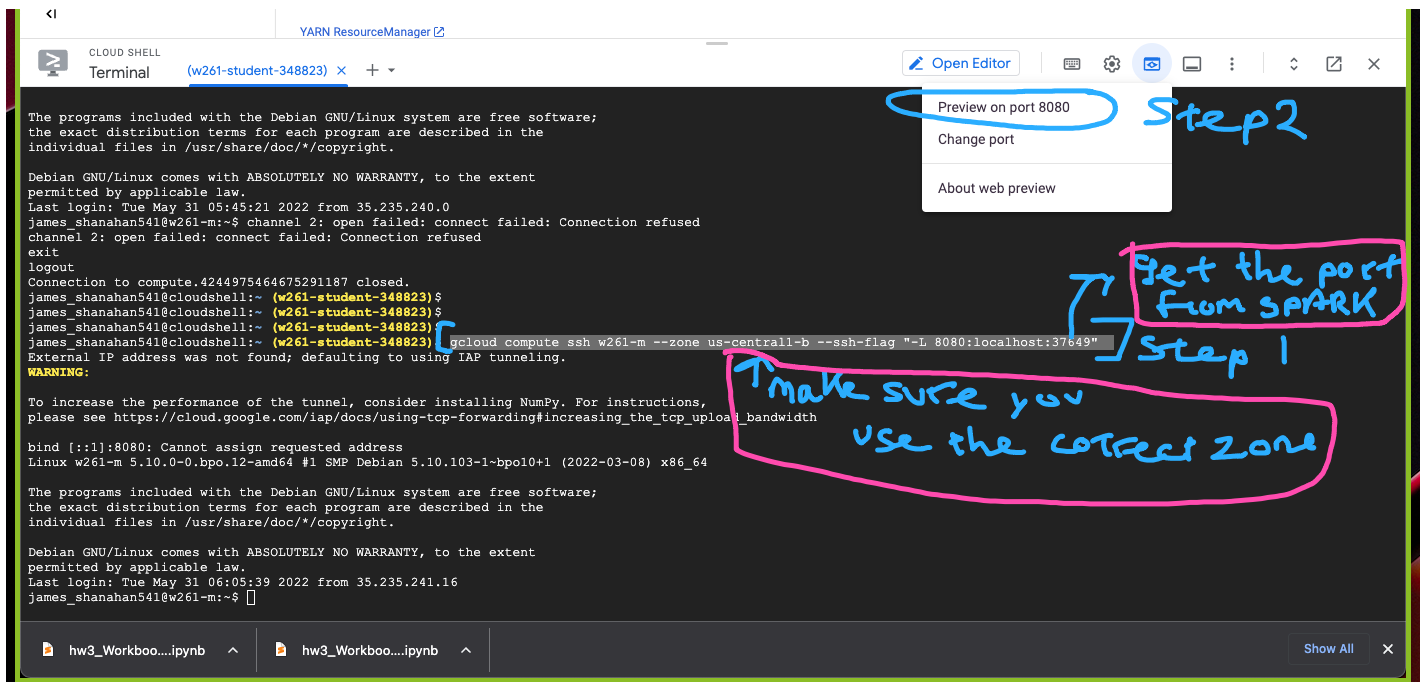

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. Answer each one very briefly - 2 to 3 sentences.

### Q1 Tasks:

* __a) short response:__ What is Spark? How  does it relate to Hadoop MapReduce?

* __b) short response:__ In what ways does Spark follow the principles of statelessness (a.k.a. functional programming)? List at least one way in which it allows the programmer to depart from this principle. 

* __c) short response:__ In the context of Spark what is a 'DAG' and how does it relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

### Q1 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

> __c)__ Type your answer here!

# Question 2: Similarity Metrics
See Canvas for Question 2.

In [ ]:
# part a
import numpy as np

np.random.seed(2)
A = np.random.randint(low=0, high=10, size=10, dtype=int)
B = np.random.randint(low=0, high=10, size=10, dtype=int)
print(f"A: {A}")
print(f"A: {B}")
print(f"A.B: {np.dot(A, B)}") 
print(f"A.B: {A @ B}") 
#Cosine similarity
cosine_sim = A @ B /......
print(f"cosine_sim(A, B): {cosine_sim:.3}")  

In [ ]:
# part b
import numpy as np
# The points below have been selected to demonstrate the case for Jaccard similarity
#Jaccard similarity
np.random.seed(2)
A = np.random.randint(low=0, high=2, size=10, dtype=int)
B = np.random.randint(low=0, high=2, size=10, dtype=int)
print(f"A: {A}")
print(f"B: {B}")
print(f"A intersection B: {np.count_nonzero(np.logical_and(A, B))}")
jaccard_sim = .... /...  # hint: np.logical_or
print(f"jaccard_sim(A, B): {jaccard_sim:.3}")  

In [ ]:
# part c
import numpy as np
# The points below have been selected to demonstrate the case for Overlap similarity
# Overlap similarity
np.random.seed(2)
A = np.random.randint(low=0, high=2, size=10, dtype=int)
B = np.random.randint(low=0, high=2, size=10, dtype=int)
print(f"A: {A}")
print(f"B: {B}")
print(f"A intersection B: {np.count_nonzero(np.logical_and(A, B))}")
overlap_sim = .... /...  # hint: min length
print(f"overlap_sim(A, B): {overlap_sim:.3}")  

In [ ]:
# part d
import numpy as np
# The points below have been selected to demonstrate the case for Dice similarity
# Dice similarity
np.random.seed(2)
A = np.random.randint(low=0, high=2, size=10, dtype=int)
B = np.random.randint(low=0, high=2, size=10, dtype=int)
print(f"A: {A}")
print(f"B: {B}")
print(f"A intersection B: {np.count_nonzero(np.logical_and(A, B))}")
dice_sim = .... /...  # hint: total non zero elements between vectors
print(f"dice_sim(A, B): {dice_sim:.3}")

# Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings.

This is where the idea of co-occurrence comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [ ]:
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [ ]:
words = list(set(re.findall(r'\w+', corpus.lower())))
print(words)

But of these 10 words, 4 are so common that they probably don't tell us very much about meaning.

In [ ]:
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [ ]:
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

Your goal in the tasks below is to assess which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) multiple choice:__ Given this six word vocabulary, how many 'pairs' of words do we want to compare? 

* __b) multiple choice:__ More generally for a n-word vocabulary how many pairwise comparisons are there to make?

* __c) code:__ In the space provided below, create a 'stripe' for each `term` in the vocabulary. This stripe should be the list of all other vocabulary words that occur within a __5 word window__ (two words on either side) of the `term`'s position in the original text (In this exercise, use ['it', 'was', 'the','of'] as stopwords, just ignore them from your 5 word vectors).

* __d) multiple choice:__ Run the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeroes? 

* __e) code:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the spot marked.

* __f) multiple choice:__ Which pairs of words have the highest 'similarity' scores? 

* __g) short response:__ Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### Q3 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

> __d)__ Type your answer here!   

> __f)__ Type your answer here! 

> __g)__ Type your answer here!

In [ ]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)
print('VOCAB:')
print(vocab)

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/best-of-times.png?raw=true' style='width:80%'>

In [ ]:
# part c - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
# Stopwords: 
#     ['it', 'was', 'the', 'of'] 
# Hint:
#     In provided sentence, age appears in two 5 word vectors: ['was', 'the', 'age', 'of', 'wisdom'] and ['was', 'the', 'age', 'of', 'foolishness']
#     After removing stopwords, the remaining words are 'wisdom' and 'foolishness'
#
#     You finish the rest of the non-stopwords below. 

stripes = {'age':['wisdom','foolishness'], # example
           'best':[], # YOU FILL IN THE REST
           'foolishness':[],
           'times': [],
           'wisdom':[],
           'worst':[]}

In [ ]:
# part d - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [ ]:
# part d - this cell 1-hot encodes the co-occurrence matrix (RUN THIS CELL AS IS) 
for term, nbrs in stripes.items():
    pass
    for nbr in nbrs:
        co_matrix.loc[term, nbr] = 1
co_matrix

In [ ]:
# part e - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]
    
    # cosine similarity
    ############# YOUR CODE HERE #################
    csim = None
    ############# (END) YOUR CODE #################    
    
    print(f"{term1}-{term2}: {csim}")

# Question 4: Pairs and Stripes at Scale

As you read in the paper by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf), the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO (Dimension Independent Similarity Computation) implementation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revisit the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) multiple choice (choose 2):__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. In the async videos about "Pairs and Stripes" you were introduced to an alternative strategy. Explain two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __b) read provided code:__ The code below provides a streamined implementation of Document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __c) short response:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. In your own words, define each of these terms ('postings' and 'inverted index') based on your reading of the provided code. (*DITP by Lin and Dyer also contains a chapter on the Inverted Index although in the context of Hadoop rather than Spark. You may find the illustration in Chaprter 4 helpful in answering this question*).

* __d) short response:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __e) multiple choice:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations, and why?

### Q4 Student Answers:

> __a)__ Type your answer here! 

> __b)__ _read provided code before answering d-e_ 

> __c)__ Type your answer here!  

> __d)__ Type your answer here!  

> __e)__ Type your answer here!

A small test file that we put in a folder on your private data bucket : __`sample_docs.txt`__ 

In [ ]:
sample_doc="""docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly"""

sample_docs_loc = f'{HW3_FOLDER}/sample_docs.txt'

!echo "{sample_doc}" | gsutil cp - {sample_docs_loc}

In [ ]:
!gsutil ls -l {HW3_FOLDER}

In [ ]:
# load data - RUN THIS CELL AS IS
!gsutil cat {sample_docs_loc}

__Document Similarity Analysis in Spark:__

In [ ]:
# load data - RUN THIS CELL AS IS
data = sc.textFile(sample_docs_loc)  

In [ ]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [ ]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [ ]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

### ignore latency warnings
NOTE: do NOT be alarmed if you see some latency warnings when you run the following command. This can happen when you are accessing your cloud bucket for the first time. Spark is super EAGER! 

In [ ]:
# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
result 
#NOTE: do NOT be alarmed if you see some latency warnings here.

# About the Data
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: "Synonym" Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available in the 'data' folder in 'Assignments/HW3/' github. Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms.

In [ ]:
!gsutil ls -lh {HW3_FOLDER}/data  #The data is preloaded into your personal data bucket (all 190 zipped files)

In [ ]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS  = f'{HW3_FOLDER}/data'
F1_PATH = f'{HW3_FOLDER}/data/googlebooks-eng-all-5gram-20090715-0-filtered.txt.gz'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [ ]:
systems_test= """it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1"""


systems_test_loc = f'{HW3_FOLDER}/systems_test.txt'

!echo "{systems_test}" | gsutil cp - {systems_test_loc}

Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [ ]:
# Spark RDDs for each dataset
testRDD = sc.textFile(systems_test_loc) 
f1RDD = sc.textFile(F1_PATH)
dataRDD = sc.textFile(NGRAMS)

Let's take a peek at what each of these RDDs looks like:

In [ ]:
testRDD.take(10)

In [ ]:
f1RDD.take(10)

In [ ]:
dataRDD.take(10)

# Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) code:__ Write a Spark application to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurances (count) of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._

* __b) numerical:__ What is the size of the vocabulary?

* __c) numerical:__ Given the vocab size you just found, how many potential synonym pairs could we form from this corpus? 

* __d) numerical:__ If each term's stripe were 1000 words long, how many tuples would we need to shuffle in order to form the inverted indices? 

* __e) short response:__ Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __f) multiple choice:__ Looking at the most frequent words and their counts, how useful will these top words be in synonym detection?

* __g) multiple choice:__ Looking at the least frequent words and their counts, what is a possible explanation of their low counts?

* __h) multiple choice:__ How reliable should we expect the detected 'synonyms' for the least frequent words to be?

### Q5 Student Answers:

> __b)__ Type your answer here!   

> __c)__ Type your answer here!   

> __d)__ Type your answer here!

> __e)__ Type your answer here!


In [ ]:
# part a - write your spark job here 
def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    ############# YOUR CODE HERE ###############

    
    
    
    
    
    
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n

In [ ]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
import time
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))


In [ ]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Expected output for testRDD:
<pre>
    Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness       1 |            the  17  
</pre>

In [ ]:
# part a - run a single file, ie., a small sample (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))


In [ ]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Expected output for f1RDD
<pre>
Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |         barnes  40
      in    7470912 |         arnall  40
       a    6926743 |     buonaparte  40
     and    6150529 |       puzzling  40
    that    4077421 |             hd  40
      is    4074864 |        corisca  40
      be    3720812 |       cristina  40
     was    2492074 |         durban  40
</pre>

In [ ]:
# part a - run full analysis (RUN THIS CELL AS IS)

start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 4 minute minutes on N1-Std-4 (4 CPUS) as May 30, 2022
# 

In [ ]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Expected output for dataRDD:
(bottom words might vary a little due to ties)
<pre>
Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |   schwetzingen  40
      of 3698583299 |           cras  40
      to 2227866570 |       parcival  40
      in 1421312776 |          porti  40
       a 1361123022 |    scribbler's  40
     and 1149577477 |      washermen  40
    that  802921147 |    viscerating  40
      is  758328796 |         mildes  40
      be  688707130 |      scholared  40
      as  492170314 |       jaworski  40
</pre>

# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) code:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  
 <pre>
  HINT: consider all words within a five-gram to be co-occuring. In other words, a word in a single 5-gram will always have 4 neighbors
  EXAMPLE:
    the dog ate cat litter 
    the cat has clean litter 
    
    Vocabulary:
    the, dog, ate, litter, cat, has, clean
    
    Neighbors:
    (the, dog) (the, ate) (the, cat) (the, littler), (dog, ate) (dog, cat) (dog, litter), (ate, cat) (ate, litter), (cat, litter)
    (the, cat) (the, has) (the, clean) (the, litter), (cat, has) (cat, clean) (cat, litter), (has, clean) (has, litter) (clean, litter)
    
    Unique neighbors:
    the 6
    dog 4
    ate 4
    litter 6
    cat 6
    has 4
    clean 4
 </pre>
    
    
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts     
  __`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers.

* __b) short response:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) code + numerical:__ Write a Spark Job to compare word frequencies to number of neighbors.
    * Of the 1000 words with most neighbors, what percent are also in the list of 1000 most frequent words?
    * Of the 1000 words with least neighbors, what percent are also in the list of 1000 least frequent words?   
[__`NOTE:`__ _technically these lists are short enough to compare in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

### Q6 Student Answers:

> __b)__ Type your answer here!   

> __c)__ Type your answer here!

In [ ]:
# part a - spark job
def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############

    
    
    
    
    
    
    
    
    
    
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [ ]:
# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 0.83 seconds -- by kyleiwaniec@gmail.com at 12/8/2020, 1:41:59 PM on HW-S21

In [ ]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

Expected output for testRDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9
 </pre>

In [ ]:
# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10, 4) #repartiion and use all 4 cores
print("Wall time: {} seconds".format(time.time() - start))
# Command took 13.80 seconds -- DCE

#[Stage 40:>                                                         (0 + 1) / 1]
#Wall time: 10.146554470062256 seconds

#[Stage 50:>                                                         (0 + 4) / 4]
# Wall time: 6.513125658035278 seconds


In [ ]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

Expected output for f1RDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |      noncleaved    2
         and    16489 |        premiers    2
          to    14249 |        enclaves    2
          in    13891 |   selectiveness    2
           a    13045 |           trill    2
        that     8011 |           pizza    2
          is     7947 |            hoot    2
        with     7552 |     palpitation    2
          by     7400 |            twel    2
</pre>

In [ ]:
# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

# Wall time: 796.3152396678925 seconds on n1-std-4 (with gunzipped txt files)

In [ ]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

Expected output for dataRDD: 
(bottom words might vary a little due to ties)
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1
</pre>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

In [ ]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)

# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')


In [ ]:
# part c - spark job
def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############

    
    
    
    
    
    ############# (END) YOUR CODE ##############
    return percent_overlap

In [ ]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(testRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(testRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

In [ ]:
#<--- SOLUTION --->
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")
# 

# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary'. Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a1) multiple choice:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?
<pre>  
   MULTIPLE CHOICE:
   A. 1000 most frequent words would overfit, while 1000 least frequent words would underfit
   B. 1000 most frequent words would underfit, while 1000 least frequent words would overfit

</pre>

* __a2) short response:__Explain your answer above
* __b) short response:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary, what alternative strategy could we take?

* __c) multiple choice:__ Run the provided spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  
<pre>
  What is another way to describe the Basis Vocabulary in machine learning terms?
  A. Stop-words
  **B. Features**
  C. Postings
  D. 1000-grams
</pre>

* __d) code:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, should return an RDD (which we will then use in q8).

### Q7 Student Answers:
> __a1)__ Type your answer here!   
> __a2)__ Type your answer here!   
> __b)__ Type your answer here!   
> __c)__ Type your answer here!

In [ ]:
# part c - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [ ]:
# part c - get the vocabulary and basis (RUN THIS CELL AS IS)
# 
def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None
    ############# YOUR CODE HERE ###############

    
    
    
    
    ############# (END) YOUR CODE ##############
    return vocab, basis

In [ ]:
# part c - run your job (RUN THIS CELL AS IS)
start = time.time()
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)
print("Wall time: {} seconds".format(time.time() - start))
# 268.0176115036011 seconds

In [ ]:
# part c - save to file (RUN THIS CELL AS IS)
#with open("vocabulary.txt", "w") as file:
#    file.write(str(VOCAB))
#with open("basis.txt", "w") as file:
#    file.write(str(BASIS))

In [ ]:
# part c - save to file (RUN THIS CELL AS IS)
!echo "{','.join(VOCAB)}" | gsutil cp - {HW3_FOLDER}/output/vocabulary.txt
!echo "{','.join(BASIS)}" | gsutil cp - {HW3_FOLDER}/output/basis.txt


In [ ]:
# part d - spark job
def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############

    
    
    
    
    
    
    ############# (END) YOUR CODE ##############
    return stripesRDD

In [ ]:
# part d - run your systems test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
print(testStripesRDD.collect())
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 0.1581110954284668 seconds
# Expected results
'''
[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]
'''

In [ ]:
# part d - run your single file test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(f1RDD, 10000, 1000)
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS).cache()
start = time.time()
print(f1StripesRDD.top(5))
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.55739426612854 seconds
# Expected results
'''
[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]
'''

In [ ]:
# part d - run the full analysis and take a look at a few stripes (RUN THIS CELL AS IS)
#VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
#BASIS = ast.literal_eval(open("basis.txt", "r").read())
wordzz= !gsutil cat {HW3_FOLDER}/output/vocabulary.txt
VOCAB = wordzz[0].split(",")
wordzz= !gsutil cat {HW3_FOLDER}/output/basis.txt
BASIS = wordzz[0].split(",")

stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 214.13801431655884 seconds
# Expected results:
'''
zones
['remotest', 'adhesion', 'residential', 'subdivided', 'environments', 'gaza', 'saturation', 'localities', 'uppermost', 'warmer', 'buffer', 'parks']
-------
zone
['tribal', 'narrower', 'fibrous', 'saturation', 'originate', 'auxiliary', 'ie', 'buffer', 'transitional', 'turbulent', 'vomiting', 'americas', 'articular', 'poorly', 'intervening', 'officially', 'accumulate', 'assisting', 'flexor', 'traversed', 'unusually', 'uppermost', 'cartilage', 'inorganic', 'illuminated', 'glowing', 'contamination', 'trigger', 'masculine', 'defines', 'avoidance', 'residential', 'southeastern', 'penis', 'cracks', 'atlas', 'excitation', 'persia', 'diffuse', 'subdivided', 'alaska', 'guides', 'au', 'sandy', 'penetrating', 'parked']
-------
zinc
['ammonium', 'coating', 'pancreas', 'insoluble', "alzheimer's", 'diamond', 'radioactive', 'metallic', 'weighing', 'dysfunction', 'wasting', 'phosphorus', 'transcription', 'dipped', 'hydroxide', 'burns', 'leukemia', 'dietary']
-------
'''

#### Checkpoint the stripes (Just RUN all cells in this section AS IS and review outputs)
Let's save your full stripes to disk. Then we can reload later if needed. We repartition our data first and then save (as otherwise, we will end up with 190 partitions; I wonder why!).

```python 
!gsutil -m rm -r {HW3_FOLDER}/stripes 2> /dev/null   ##remove old results
stripesRDD.repartition(4).saveAsTextFile(f'{HW3_FOLDER}/stripes')  #repartition and write partitions to Google Cloud Bucket
!gsutil ls -lh {HW3_FOLDER}/stripes 
```

The above produces the following output directory: 
```
       0 B  2022-05-31T05:35:02Z  gs://w261-jgs/main/Assignments/HW3/docker/student/stripes/
       0 B  2022-05-31T05:35:03Z  gs://w261-jgs/main/Assignments/HW3/docker/student/stripes/_SUCCESS
  1.74 MiB  2022-05-31T05:35:02Z  gs://w261-jgs/main/Assignments/HW3/docker/student/stripes/part-00000
   1.6 MiB  2022-05-31T05:35:01Z  gs://w261-jgs/main/Assignments/HW3/docker/student/stripes/part-00001
  1.58 MiB  2022-05-31T05:35:02Z  gs://w261-jgs/main/Assignments/HW3/docker/student/stripes/part-00002
  1.52 MiB  2022-05-31T05:35:01Z  gs://w261-jgs/main/Assignments/HW3/docker/student/stripes/part-00003
TOTAL: 6 objects, 6745577 bytes (6.43 MiB)
```

The following code displays the stripe of cooccurence words for the term `sea`:

```python
!gsutil cat {HW3_FOLDER}/stripes/part-00000|head -n 1
```
```python
('sea', {'sweeping', 'twisted', 'athenians', 'fog', 'tumult', 'repression', 'morphology', 'jane', 'secreted', 'tents', 'barred', 'sadness', 'hamlet', 'turbulent', 'rains', 'robe', 'imagery', 'myths', 'orient', 'intervening', 'victories', 'accumulate', 'sinners', 'constancy', 'strained', 'sermons', 'shoe', 'trembled', 'merged', 'eastward', 'avoidance', 'sensibility', 'informing', 'silently', 'dip', 'surround', 'blocked', 'voyages', 'bursting', 'vastly', 'southeastern', 'cracks', 'tore', 'temperament', "ship's", 'odor', 'atlas', 'matthew', 'ether', 'colonization', 'irresistible', 'shells', 'alaska', 'gaza', 'distributions', 'farthest', 'silly', 'flush', 'ugly', 'transparent', 'arabian', 'sandy', 'steering', 'penetrating', 'burns', 'norway', 'thames', 'moonlight', 'plunge', 'beset', 'yielding', 'tuesday', 'impacts', 'cheese', 'convex', 'armistice', 'polished', 'freshness', 'belgium', 'saturation', 'dumb', 'spoil', 'shines', 'sunset', 'softly', 'laden', 'realms', 'alexandria', 'parallels', 'weep', 'ushered', 'violently', 'expanse', 'travellers', 'insoluble', 'downs', 'roofs', 'filtered', 'ashore', 'graces', 'obscured', 'establishments', 'traversed', 'crystalline', 'warmer', 'skins', 'viewing', 'fascination', 'liverpool', 'contamination', 'sails', 'masculine', 'usages', 'bucket', 'dipped', 'dew', 'fare', 'overlooking', 'necks', 'sticks', 'weighing', 'danube', 'mast', 'phosphorus', 'mate', 'attested', 'anonymous', 'wax', 'finishing', 'parked', 'flocks', 'humidity', 'endurance', 'terrors', 'carpet', 'misfortunes', 'hydroxide', 'crazy', 'priesthood', 'hungary', 'nova', 'believeth', 'remotest', 'occupants', 'complexion', 'floors', 'stationary', 'provoked', 'osmotic', 'spoils', 'clearance', 'hangs', 'openings', 'halfway', 'inorganic', 'nursery', 'vigilance', 'conqueror', 'ft', 'feathers', 'roses', 'emblem', 'lawn', 'damp', 'switzerland', 'drinks', 'contradictory', 'drained', 'ordinances', 'captains', 'barren', 'steamer', 'pursuits', 'storms', 'wasting', 'frankly', 'sequences', 'pitched', 'aggravated', 'viceroy', 'leaped', 'cunning', 'simon', 'marching', 'lends', 'sherman', 'centered', 'genome', 'iran', 'sued', 'imputed', 'perilous', 'desperately', 'southward', 'maiden', 'unusually', 'crosses', 'revealing', 'uppermost', 'remission', 'inherit', 'sunny', 'ink', 'restless', 'lighting', 'serpent', 'scarlet', 'hebrews', 'flourish', 'terminology', 'bidding', 'autobiography', 'despise', 'signification', 'preparatory', 'radioactive', 'drying', 'persia', 'unfamiliar', 'twist', 'fiery', 'boon', 'delights', 'commonest', 'bounty', 'traders', 'whoever'})
```

In [ ]:
# part d - save your full stripes to file for ease of retrival later... Please run code as is 
!gsutil -m rm -r {HW3_FOLDER}/stripes 2> /dev/null   ##remove old results
stripesRDD.repartition(4).saveAsTextFile(f'{HW3_FOLDER}/stripes')  #repartition and write partitions to Google Cloud Bucket

In [ ]:
# part d - list all partitions in the saved output folder... (RUN THIS CELL AS IS)
!gsutil ls -lh {HW3_FOLDER}/stripes 

In [ ]:
# part d - display word stripes for a couple of terms... (RUN THIS CELL AS IS)
!gsutil cat {HW3_FOLDER}/stripes/part-00000|head -n 2

# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

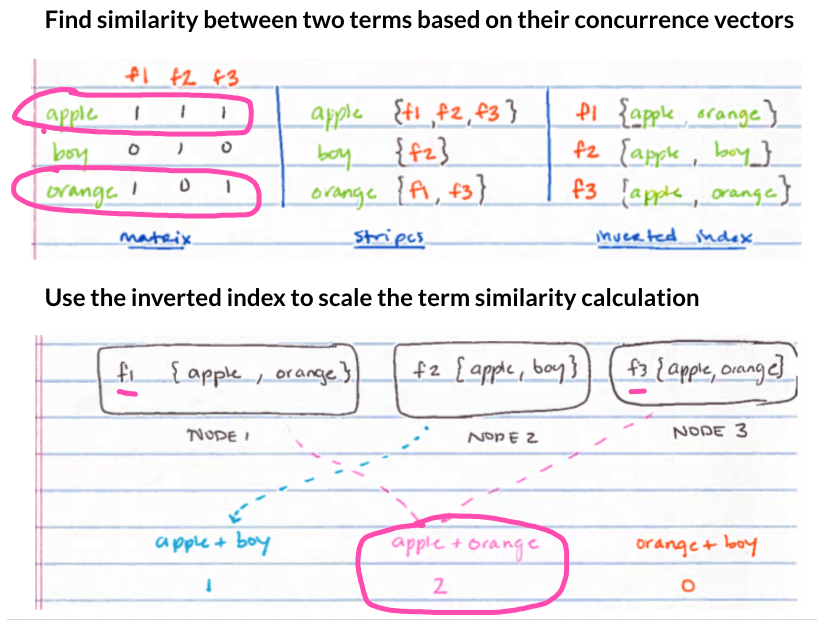

### Q8 Tasks:

* __a1) multiple choice on Canvas:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. What is the 'feature space' for this representation?

* __a2) multiple choice on Canvas:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning.  What is the maximum length of a stripe?

* __b) multiple choice on Canvas:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.'  How many rows will there be in our inverted index?

* __c) short response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index?

* __d) code:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` _(key:term, value:posting)_   
  * aggregates the postings to create an inverted index _(key:term, value:list of postings)_
  * loops over all pairs of `term`s that appear in the same postings list and emits co-occurrence counts
  * aggregates co-occurrences _(key:word pair, value:count + other payload)_
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also return the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._
  
* __e) code:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

### Q8 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

> __c)__ Type your answer here!

> __e)__ Type your answer here!

In [ ]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for pair, scores in lines:
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```

In [ ]:
# part d - write your spark job in the space provided
def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############### YOUR CODE HERE ################
   






















    ############### (END) YOUR CODE ##############
    return result, top_n, bottom_n

In [ ]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.4768586158752441 seconds

In [ ]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.9845571517944336 seconds

In [ ]:
displayOutput(top_n)

In [ ]:
displayOutput(bottom_n)

In [ ]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))
# Command took 14 minutes -- May 30, 2022 on GC n1-std-4

In [ ]:
displayOutput(top_n)

In [ ]:
displayOutput(bottom_n)

__Expected output f1RDD:__  
<table>
<th>MOST SIMILAR:</th>
<th>LEAST SIMILAR:</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
commentary - lady        |   1.0,     1.0,     1.0,   1.0
commentary - toes        |   1.0,     1.0,     1.0,   1.0
commentary - reply       |   1.0,     1.0,     1.0,   1.0
curious - tone           |   1.0,     1.0,     1.0,   1.0
curious - lady           |   1.0,     1.0,     1.0,   1.0
curious - owe            |   1.0,     1.0,     1.0,   1.0
lady - tone              |   1.0,     1.0,     1.0,   1.0
reply - tone             |   1.0,     1.0,     1.0,   1.0
lady - toes              |   1.0,     1.0,     1.0,   1.0
lady - reply             |   1.0,     1.0,     1.0,   1.0
</pre></td>
<td><pre>

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
time - two               |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
new - time               |0.0352,  0.0175,  0.0435, 0.0345
part - us                |0.0355,  0.0179,  0.0417, 0.0351
little - part            |0.0355,  0.0179,  0.0417, 0.0351
made - two               |0.0357,  0.0182,   0.037, 0.0357
made - upon              |0.0357,  0.0182,   0.037, 0.0357
</pre></td></tr>
</table>

__Expected output dataRDD:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,   0.889, 0.8433
new - time               |0.8426,   0.724,  0.9133, 0.8399
first - two              |0.8411,  0.7249,  0.8737, 0.8405
way - well               |0.8357,  0.7146,  0.8986, 0.8335
time - us                |0.8357,  0.7105,  0.9318, 0.8308

</pre></td>
<td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
region - write           |0.0067,  0.0032,  0.0085, 0.0065
relation - snow          |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took           |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor             |0.0076,   0.002,  0.0263, 0.004
came - tumor             |0.0076,   0.002,  0.0263, 0.004
let - therapy            |0.0076,   0.003,  0.0161, 0.0059
related - stay           |0.0078,  0.0036,  0.0116, 0.0072
factors - hear           |0.0078,  0.0039,  0.0094, 0.0077
implications - round     |0.0078,  0.0033,  0.0145, 0.0066
came - proteins          |0.0079,   0.002,  0.0286, 0.0041
population - window      |0.0079,  0.0039,    0.01, 0.0077
love - proportional      | 0.008,  0.0029,  0.0185, 0.0058
got - multiple           | 0.008,  0.0034,  0.0149, 0.0067
changes - fort           |0.0081,  0.0032,  0.0161, 0.0065
layer - wife             |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy          |0.0081,  0.0034,  0.0149, 0.0068
arrival - essential      |0.0081,   0.004,  0.0093, 0.008
desert - function        |0.0081,  0.0031,  0.0175, 0.0062
fundamental - stood      |0.0081,  0.0038,  0.0115, 0.0077
patients - plain         |0.0081,   0.004,  0.0103, 0.0079
</pre></td></tr>
</table>

### Congratulations, you have completed HW3! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform